In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
import time

import shap

import feature_engine.selection as fsel
import feature_engine.outliers as fout
from feature_engine.transformation import LogTransformer

from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn import model_selection as mod
from sklearn import ensemble as ens
from sklearn import pipeline as pip
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb
import optuna

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_predictions(df, predicted, ticker, rnn_type = False, dropout = False, epochs = False, num_layers = False, activation_function = False, batch_size = False, elapsed_time = False, classification = False, line = False, open_ = False):
    
    """
    Visualizes the actual versus predicted prices using bar charts and line graphs.
    
    Parameters:
    - df (DataFrame): DataFrame containing the original data.
    - predicted (list): Predicted values from the model.
    - ticker (str): Stock ticker symbol.
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - batch_size (int): Size of each training batch.
    - activation_function (str): Activation function for LSTM layers.
    - num_layers (int): Number of LSTM layers.
    - classification (bool): If true, indicates this is a classification task. Default is False.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_predictions(df = df,
                     predicted = predicted_price_NASDAQ_LSTM,
                     ticker = ticker,
                     rnn_type = rnn_type,
                     dropout = dropout,
                     epochs = epoch,
                     num_layers=num_layers,
                     activation_function=activation_function,
                     batch_size = batch_size,
                     elapsed_time = elapsed_time,
                     classification = False,
                     line = False)
    
    """
    target = "Close"
    if open_:
        target = "Open"
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(predicted):]
    if line:
        ax.plot(bar_df.index, bar_df[target], color='red', label=f'{ticker} {target}ing Price', linewidth=1, marker = "o")
    else:
        color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df[target], bar_df["Open"])]
        candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
        ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    if classification:
        actual = (df[target].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])[-len(predicted):]).astype(int).values
        errors = [i for i, (a, c) in enumerate(zip(actual, predicted)) if a != c]
        for err in errors:
            ax.axvline(x=bar_df.index[err], color='blue', linestyle='dotted', label='Misclassification' if 'Misclassification' not in [l.get_label() for l in ax.lines] else "")
    else:
        if line:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} {target}ing Price', linewidth=1, marker = "o")
        else:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} {target}ing Price', linewidth=1)
    ax.legend()
    
    title = []
    if epochs:
        title.append(f'# of Epochs: {epochs}, ')
    if elapsed_time:
        title.append(f'Computation Time: {elapsed_time} Seconds, ')
    if batch_size:
        title.append(f'Batch Size: {batch_size}, ')
    if activation_function:
        title.append(f'Activation Function: {activation_function}, ')
    if num_layers:
        title.append(f'# of Layers: {num_layers}, Dropout: {dropout}, ')
    if rnn_type:
        title.append(f'RNN Type: {rnn_type}, ')

    if len(title) > 0:
        title = ''.join(title)[:-2]
    else:
        title = ticker

    ax.set_title(title , fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} {target}ing Price')
    plt.tight_layout()
    plt.show()
    
def add_technical_indicators(df_orig):
    
    """
    Add technical indicators to the given dataframe of stock data.

    Parameters:
    - df (pd.DataFrame): A dataframe containing stock data with columns like 'Open', 'Close', 'High', 'Low', etc.
                         The index should be the date.

    Returns:
    - pd.DataFrame: The dataframe enriched with technical indicators.

    Added Indicators:
    1. Day of the week as sine/cosine encoding
    2. Week of the year as sine/cosine encoding
    3. Percentage change of 'Close' and 'Open' from the previous day
    4. Winning indicator for 'Close' and 'Open' (1 if positive percentage change, otherwise 0)
    5. Simple Moving Averages (SMA) for 50 and 200 days
    6. Relative Strength Index (RSI) for 14 days
    7. Momentum (Close difference from 4 days ago)
    8. Stochastic Oscillator (%K and %D for 14 days)
    9. Exponential Moving Averages (EMA) for 12 and 26 days and Moving Average Convergence Divergence (MACD)
    10. Average True Range (ATR) for 14 days
    11. On-Balance Volume (OBV)
    12. Bollinger Bands (Middle, Upper, Lower Band for 20 days)

    Note:
    - The function assumes certain columns are present in the dataframe ('Open', 'Close', 'High', 'Low', etc.)
    - The function will remove the original 'High', 'Low', 'Dividends', and 'Stock Splits' columns from the dataframe.
    - The index will be set to only the date, removing any timestamp if present.
    """
    df = df_orig.copy()
    df["dayofweek"]  = pd.to_datetime(df.index).dayofweek    
    df["weekofyear"] = pd.to_datetime(df.index).isocalendar().week.astype("int64")
    df["pct_close"]  = df["Close"].pct_change().shift(-1) * 100
    df["pct_open"]   = pd.Series((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1) * 100
    
    def cycle_encode(data, cols):
        for col in cols:
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        return data

    cols  = ["dayofweek","weekofyear"]
    df = cycle_encode(df,cols)
    df.drop(cols, axis=1, inplace=True)
     
    df['SMA_50'] = ((df['Close'] - df['Close'].rolling(window=50).mean()) / df['Close'].rolling(window=50).mean()) * 100
    df['SMA_100'] = ((df['Close'] - df['Close'].rolling(window=100).mean()) / df['Close'].rolling(window=100).mean()) * 100
    df['SMA_200'] = ((df['Close'] - df['Close'].rolling(window=200).mean()) / df['Close'].rolling(window=200).mean()) * 100

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['Momentum'] = df['Close'] - df['Close'].shift(4)

    low_min  = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['%K'] = (df['Close'] - low_min) * 100 / (high_max - low_min)
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    df['EMA_8'] = ((df['Close'] - df['Close'].ewm(span=8).mean()) / df['Close'].ewm(span=8).mean()) * 100
    df['EMA_12'] = ((df['Close'] - df['Close'].ewm(span=12).mean()) / df['Close'].ewm(span=12).mean()) * 100
    df['EMA_26'] = ((df['Close'] - df['Close'].ewm(span=26).mean()) / df['Close'].ewm(span=26).mean()) * 100
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()

    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(np.abs(df['High'] - df['Close'].shift(1)), 
                                     np.abs(df['Low'] - df['Close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=14).mean()

    df['OBV'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                        np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0)).cumsum()

    df['Middle_Band'] = ((df['Close'] - df['Close'].rolling(window=20).mean()) / df['Close'].rolling(window=20).mean()) * 100
    df['Upper_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) * 100
    df['Lower_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) * 100
    df['vol_pct_change'] = df["Volume"].pct_change()
    
    df.drop(["High", "Low", "Dividends", "Stock Splits"], axis = 1, inplace = True)

    return df

def get_indices_pct_change(indices):
    
    """
    Fetches historical closing prices for the given stock indices and merges them into a single DataFrame.
    
    Parameters:
    indices (list): A list of stock indices for which to fetch historical data.
    
    Returns:
    DataFrame: A DataFrame where each column represents the closing prices for one index, and rows are indexed by date.
    """
    
    data = {index: yf.Ticker(index).history(period="max") for index in indices}

    sorted_indices = sorted(data.keys(), key=lambda x: len(data[x]), reverse=True)

    base_index = sorted_indices[0]
    df_indices = data[base_index][["Close"]]
    df_indices.columns = [base_index]
    df_indices.index = df_indices.index.date

    for index in sorted_indices[1:]:
        df_indice = data[index][["Close"]]
        df_indice.index = df_indice.index.date
        df_indice.columns = [index]
        df_indices = pd.merge(df_indices, df_indice, left_index=True, right_index=True, how='outer')
    return df_indices

class LogTransformer(BaseEstimator, TransformerMixin):
    
    """
    Transforms specified columns of a DataFrame using the natural logarithm function.
    
    Parameters:
    columns (list): A list of column names that will be transformed.
    """
    
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        
        """
        Fit method for LogTransformer, does nothing as this transformation doesn't require fitting.
        
        Parameters:
        X (DataFrame): The input data. Not used.
        y (array-like): The target data. Not used.
        
        Returns:
        self: Returns the instance itself.
        """
        
        return self

    def transform(self, X):
        
        """
        Applies the natural logarithm transformation to specified columns of the DataFrame.
        
        Parameters:
        X (DataFrame): The input data to be transformed.
        
        Returns:
        DataFrame: A DataFrame with transformed columns.
        """
        
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.log1p(X_copy[col])
        return X_copy

In [3]:
columns_with_outliers    = ['Volume', 'SMA_50', 'SMA_100', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'TR', 'ATR', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'vol_pct_change']
columns_to_log_transform = ['Volume', 'Momentum', 'TR', 'ATR', 'OBV', 'Upper_Band', 'Lower_Band', 'vol_pct_change']

explanations = [] #explanation, best params, f1, TN, FP, FN, TP, "accuracy", "precision", "recall"

nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date

df_NASDAQ_technical = add_technical_indicators(df_NASDAQ)
df_NASDAQ_technical["pct_close"] = df_NASDAQ_technical["pct_close"].shift(-1)
df_NASDAQ_technical = df_NASDAQ_technical[df_NASDAQ_technical.Volume != 0]
df_NASDAQ_technical.dropna(inplace=True)
df_NASDAQ_technical = df_NASDAQ_technical.iloc[1:]

min_momentum = df_NASDAQ_technical.Momentum.min()
min_OBV = df_NASDAQ_technical.OBV.min()
min_Upper_Band = df_NASDAQ_technical.Upper_Band.min()
min_Lower_Band = df_NASDAQ_technical.Lower_Band.min()
min_vol_pct_change = df_NASDAQ_technical.vol_pct_change.min()

df_NASDAQ_technical.loc[:, 'Momentum']       = df_NASDAQ_technical['Momentum'] - min_momentum + 1
df_NASDAQ_technical.loc[:, 'OBV']            = df_NASDAQ_technical['OBV'] - min_OBV + 1
df_NASDAQ_technical.loc[:, 'Upper_Band']     = df_NASDAQ_technical['Upper_Band'] - min_Upper_Band + 1
df_NASDAQ_technical.loc[:, 'Lower_Band']     = df_NASDAQ_technical['Lower_Band'] - min_Lower_Band + 1
df_NASDAQ_technical.loc[:, 'vol_pct_change'] = df_NASDAQ_technical['vol_pct_change'] - min_vol_pct_change + 1

df_NASDAQ_technical['green_candle'] = np.where(df_NASDAQ_technical['pct_close'] > 0, 1, 0)
df_NASDAQ_technical["green_candle"] = df_NASDAQ_technical["green_candle"].shift(-1)
df_NASDAQ_technical.dropna(inplace = True)

## Predicting NASDAQ Close Price with XGBoost using Only Technical Indicators

In [4]:
target = "green_candle"

func_list = ["Only technical indicators"]

look_back = 30
test_coef = 20

X = df_NASDAQ_technical.drop([target, 'pct_close', 'pct_close'], axis = 1)
y = df_NASDAQ_technical[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)

    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ('scaler', pre.MinMaxScaler()),
        ('classifier', xgb.XGBClassifier(objective="binary:logistic",
                                         eval_metric="logloss", 
                                         random_state=42, 
                                         n_estimators=n_estimators, 
                                         learning_rate=learning_rate, 
                                         max_depth=max_depth, 
                                         gamma=gamma))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return met.f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-08-31 18:53:25,899] A new study created in memory with name: no-name-93a20b37-e56d-400a-9ec4-245492f8e282


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-31 18:53:45,024] Trial 9 finished with value: 0.3682604272634792 and parameters: {'n_estimators': 158, 'learning_rate': 0.04501452174870922, 'max_depth': 9, 'gamma': 0.007568840825646403}. Best is trial 9 with value: 0.3682604272634792.
[I 2023-08-31 18:53:58,637] Trial 5 finished with value: 0.32473118279569896 and parameters: {'n_estimators': 193, 'learning_rate': 0.039329626935743295, 'max_depth': 11, 'gamma': 0.012328403722276678}. Best is trial 9 with value: 0.3682604272634792.
[I 2023-08-31 18:54:00,201] Trial 1 finished with value: 0.4301675977653631 and parameters: {'n_estimators': 191, 'learning_rate': 0.04722195766428561, 'max_depth': 12, 'gamma': 0.01862897772169767}. Best is trial 1 with value: 0.4301675977653631.
[I 2023-08-31 18:54:01,982] Trial 0 finished with value: 0.4035785288270378 and parameters: {'n_estimators': 282, 'learning_rate': 0.014788770613145708, 'max_depth': 9, 'gamma': 0.003791505433126686}. Best is trial 1 with value: 0.4301675977653631.
[I 2

[I 2023-08-31 18:56:15,226] Trial 32 finished with value: 0.459045904590459 and parameters: {'n_estimators': 309, 'learning_rate': 0.005024290327984153, 'max_depth': 10, 'gamma': 0.014554012828350784}. Best is trial 36 with value: 0.5910701630049611.
[I 2023-08-31 18:56:15,753] Trial 28 finished with value: 0.4829991281604185 and parameters: {'n_estimators': 381, 'learning_rate': 0.0035539575599905504, 'max_depth': 10, 'gamma': 0.01400175724046424}. Best is trial 36 with value: 0.5910701630049611.
[I 2023-08-31 18:56:18,606] Trial 40 finished with value: 0.5487139516757599 and parameters: {'n_estimators': 102, 'learning_rate': 0.00834567463133611, 'max_depth': 9, 'gamma': 0.016690050525608624}. Best is trial 36 with value: 0.5910701630049611.
[I 2023-08-31 18:56:19,403] Trial 41 finished with value: 0.5171288743882545 and parameters: {'n_estimators': 103, 'learning_rate': 0.009189847042654669, 'max_depth': 9, 'gamma': 0.016859648196309127}. Best is trial 36 with value: 0.59107016300496

[I 2023-08-31 18:57:15,816] Trial 61 finished with value: 0.4970313825275658 and parameters: {'n_estimators': 158, 'learning_rate': 0.0011168018679851128, 'max_depth': 11, 'gamma': 0.018971897308224187}. Best is trial 63 with value: 0.6024930747922437.
[I 2023-08-31 18:57:16,126] Trial 67 finished with value: 0.5941422594142259 and parameters: {'n_estimators': 170, 'learning_rate': 0.0017712403982631211, 'max_depth': 8, 'gamma': 0.019184305000549358}. Best is trial 63 with value: 0.6024930747922437.
[I 2023-08-31 18:57:16,362] Trial 68 finished with value: 0.5973665973665974 and parameters: {'n_estimators': 163, 'learning_rate': 0.00128413698348212, 'max_depth': 8, 'gamma': 0.013556092126660221}. Best is trial 63 with value: 0.6024930747922437.
[I 2023-08-31 18:57:24,850] Trial 72 finished with value: 0.602076124567474 and parameters: {'n_estimators': 167, 'learning_rate': 0.0010446537213509694, 'max_depth': 8, 'gamma': 0.01917330558851752}. Best is trial 63 with value: 0.6024930747922

[I 2023-08-31 18:58:19,669] Trial 97 finished with value: 0.5733137829912023 and parameters: {'n_estimators': 216, 'learning_rate': 0.00278743284330936, 'max_depth': 8, 'gamma': 0.017433829671109763}. Best is trial 63 with value: 0.6024930747922437.


In [5]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 0.6024930747922437
Params: 
    n_estimators: 147
    learning_rate: 0.0012218674209143019
    max_depth: 8
    gamma: 0.01906927885104063


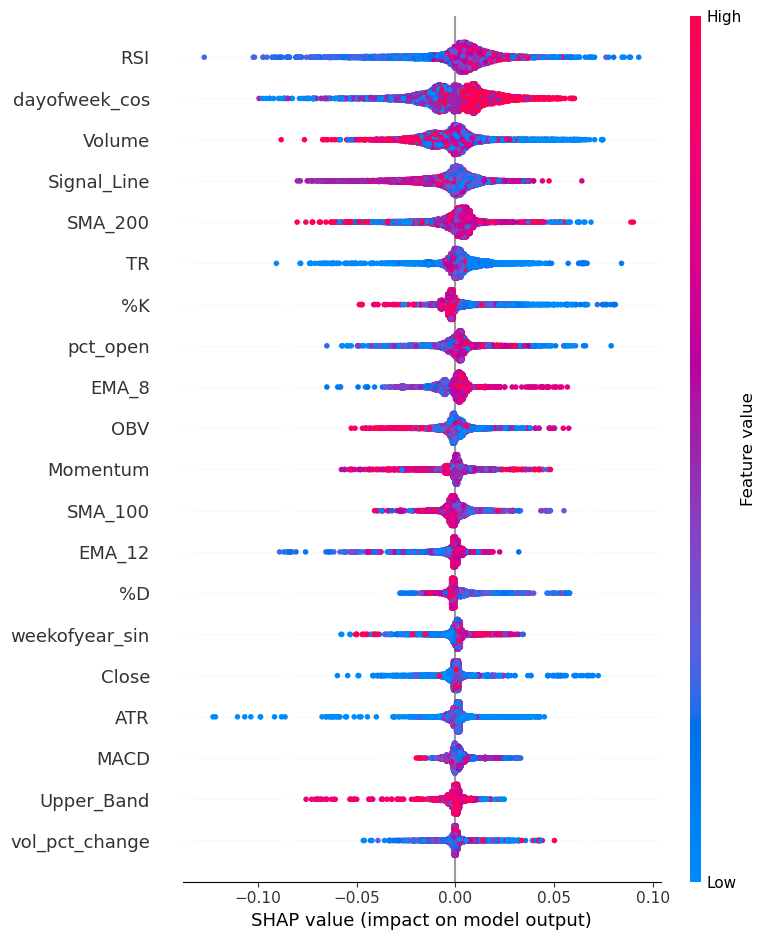

In [6]:
best_params = study.best_params

best_model = xgb.XGBClassifier(objective="binary:logistic",
                               eval_metric="logloss", 
                               random_state=42,
                               n_estimators=best_params['n_estimators'],
                               learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'],
                               gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

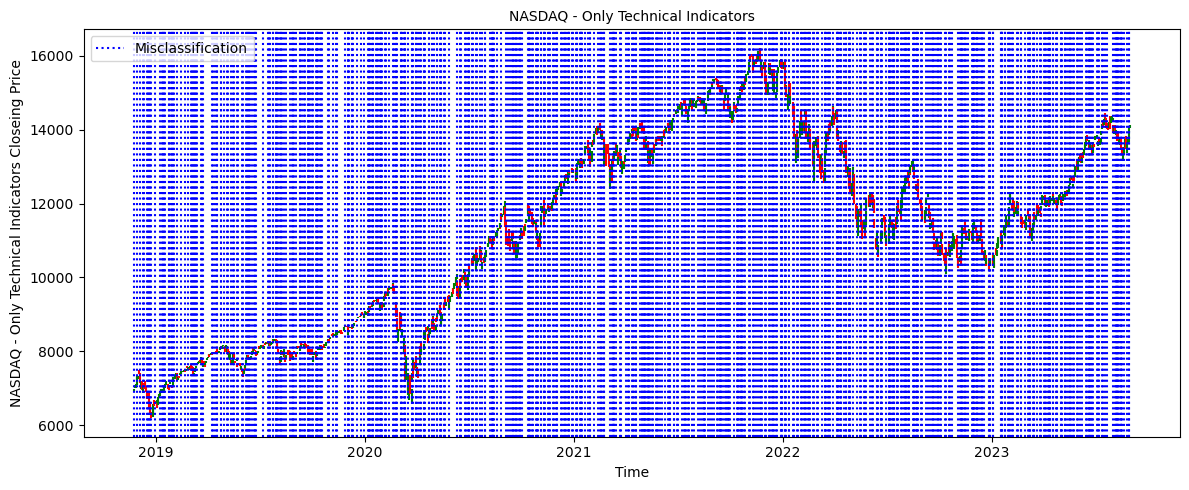

In [7]:
plot_df = df_NASDAQ

plot_predictions(plot_df,
                 y_pred,
                 ticker = "NASDAQ - Only Technical Indicators",
                 classification = True)

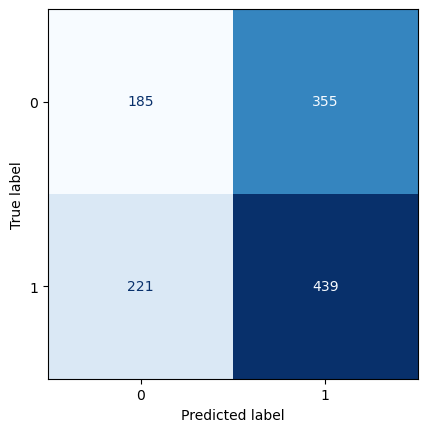

In [8]:
cf_matrix = met.confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, y_pred)
func_list.append(accuracy)
precision = met.precision_score(y_test, y_pred)
func_list.append(precision)
recall = met.recall_score(y_test, y_pred)
func_list.append(recall)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

## Predicting NASDAQ Close Price with XGBoost using Technical Indicators and Other Indices

In [9]:
indices = [
    "BTC-USD",
    "^VIX",    # CBOE Volatility Index (VIX)
    "^DJI",    # Dow Jones Industrial Average
    "^GSPC",   # S&P 500 Index
    "^FTSE",   # FTSE 100 Index (UK)
    "^GDAXI",  # DAX 30 Index (Germany)
    "^FCHI",   # CAC 40 Index (France)
    "^N225",   # Nikkei 225 Index (Japan)
    "^HSI",    # Hang Seng Index (Hong Kong)
    "^AXJO",   # S&P/ASX 200 Index (Australia)
    "^KS11",   # KOSPI Composite Index (South Korea)
    "^BSESN",  # BSE SENSEX (India)
    "^BVSP",   # Bovespa Index (Brazil)
    "GC=F",    # Gold Futures
    "SI=F",    # Silver Futures
    "CL=F",    # Crude Oil WTI Futures
    "NG=F",    # Natural Gas Futures
    "ZC=F",    # Corn Futures
    "ZW=F",    # Wheat Futures
]

In [10]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date

df_indices = get_indices_pct_change(indices)
final_df = pd.concat([df_indices, df_NASDAQ], axis = 1)
final_df.fillna(method = "ffill", inplace=True)
final_df = add_technical_indicators(final_df)
final_df["pct_close"] = final_df["pct_close"].shift(-1)

for idx in indices:
    final_df[idx] = final_df[idx].pct_change()

final_df = final_df[final_df.Volume != 0]
final_df.dropna(inplace=True)
final_df = final_df.iloc[1:]

min_momentum = final_df.Momentum.min()
min_OBV = final_df.OBV.min()
min_Upper_Band = final_df.Upper_Band.min()
min_Lower_Band = final_df.Lower_Band.min()
min_vol_pct_change = final_df.vol_pct_change.min()

final_df.loc[:, 'Momentum']       = final_df['Momentum'] - min_momentum + 1
final_df.loc[:, 'OBV']            = final_df['OBV'] - min_OBV + 1
final_df.loc[:, 'Upper_Band']     = final_df['Upper_Band'] - min_Upper_Band + 1
final_df.loc[:, 'Lower_Band']     = final_df['Lower_Band'] - min_Lower_Band + 1
final_df.loc[:, 'vol_pct_change'] = final_df['vol_pct_change'] - min_vol_pct_change + 1

final_df['green_candle'] = np.where(final_df['pct_close'] > 0, 1, 0)

In [11]:
func_list = ["Technical Indicators and Other Indices"]

X = final_df.drop([target, 'pct_open', 'pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-08-31 18:58:51,641] A new study created in memory with name: no-name-a19dea94-8286-47da-93b2-c317d2c9fc8e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-31 18:58:57,411] Trial 2 finished with value: 0.53318335208099 and parameters: {'n_estimators': 155, 'learning_rate': 0.01671972245188165, 'max_depth': 8, 'gamma': 0.011688542436556867}. Best is trial 2 with value: 0.53318335208099.
[I 2023-08-31 18:58:58,278] Trial 6 finished with value: 0.4850746268656717 and parameters: {'n_estimators': 123, 'learning_rate': 0.005258170336975986, 'max_depth': 10, 'gamma': 0.01528327324688903}. Best is trial 2 with value: 0.53318335208099.
[I 2023-08-31 18:58:58,389] Trial 9 finished with value: 0.49534883720930234 and parameters: {'n_estimators': 200, 'learning_rate': 0.047304264000287845, 'max_depth': 8, 'gamma': 0.016093717420508916}. Best is trial 2 with value: 0.53318335208099.
[I 2023-08-31 18:58:58,682] Trial 11 finished with value: 0.5446527012127894 and parameters: {'n_estimators': 118, 'learning_rate': 0.034884286725506544, 'max_depth': 12, 'gamma': 0.001794040283965066}. Best is trial 11 with value: 0.5446527012127894.
[I 2023-0

[I 2023-08-31 18:59:44,431] Trial 37 finished with value: 0.5537459283387621 and parameters: {'n_estimators': 270, 'learning_rate': 0.0401354216944321, 'max_depth': 13, 'gamma': 0.013971636416170479}. Best is trial 18 with value: 0.5630252100840336.
[I 2023-08-31 18:59:46,020] Trial 33 finished with value: 0.5539803707742639 and parameters: {'n_estimators': 352, 'learning_rate': 0.02304738080677224, 'max_depth': 13, 'gamma': 0.013665492355638907}. Best is trial 18 with value: 0.5630252100840336.
[I 2023-08-31 18:59:46,997] Trial 34 finished with value: 0.5345413363533408 and parameters: {'n_estimators': 352, 'learning_rate': 0.022154551588705114, 'max_depth': 13, 'gamma': 0.013934495496626488}. Best is trial 18 with value: 0.5630252100840336.
[I 2023-08-31 18:59:48,339] Trial 35 finished with value: 0.5414847161572053 and parameters: {'n_estimators': 364, 'learning_rate': 0.022163738008362976, 'max_depth': 13, 'gamma': 0.013834664201267}. Best is trial 18 with value: 0.5630252100840336

[I 2023-08-31 19:00:28,532] Trial 66 finished with value: 0.5520169851380042 and parameters: {'n_estimators': 239, 'learning_rate': 0.029542478546288456, 'max_depth': 11, 'gamma': 0.011434342697889451}. Best is trial 48 with value: 0.5714285714285714.
[I 2023-08-31 19:00:29,297] Trial 67 finished with value: 0.5513513513513514 and parameters: {'n_estimators': 231, 'learning_rate': 0.030478567755237326, 'max_depth': 11, 'gamma': 0.01118015930269644}. Best is trial 48 with value: 0.5714285714285714.
[I 2023-08-31 19:00:29,868] Trial 70 finished with value: 0.5172004744958482 and parameters: {'n_estimators': 227, 'learning_rate': 0.030620460859032448, 'max_depth': 10, 'gamma': 0.01901090998952749}. Best is trial 48 with value: 0.5714285714285714.
[I 2023-08-31 19:00:30,818] Trial 69 finished with value: 0.5532381997804611 and parameters: {'n_estimators': 230, 'learning_rate': 0.030594784165737583, 'max_depth': 11, 'gamma': 0.015851248301254273}. Best is trial 48 with value: 0.571428571428

[I 2023-08-31 19:01:00,374] Trial 99 finished with value: 0.5554335894621295 and parameters: {'n_estimators': 219, 'learning_rate': 0.027370454086367377, 'max_depth': 11, 'gamma': 0.014979138862607638}. Best is trial 91 with value: 0.5776330076004343.


In [12]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 0.5776330076004343
Params: 
    n_estimators: 216
    learning_rate: 0.026972102060516413
    max_depth: 12
    gamma: 0.017351046106728014


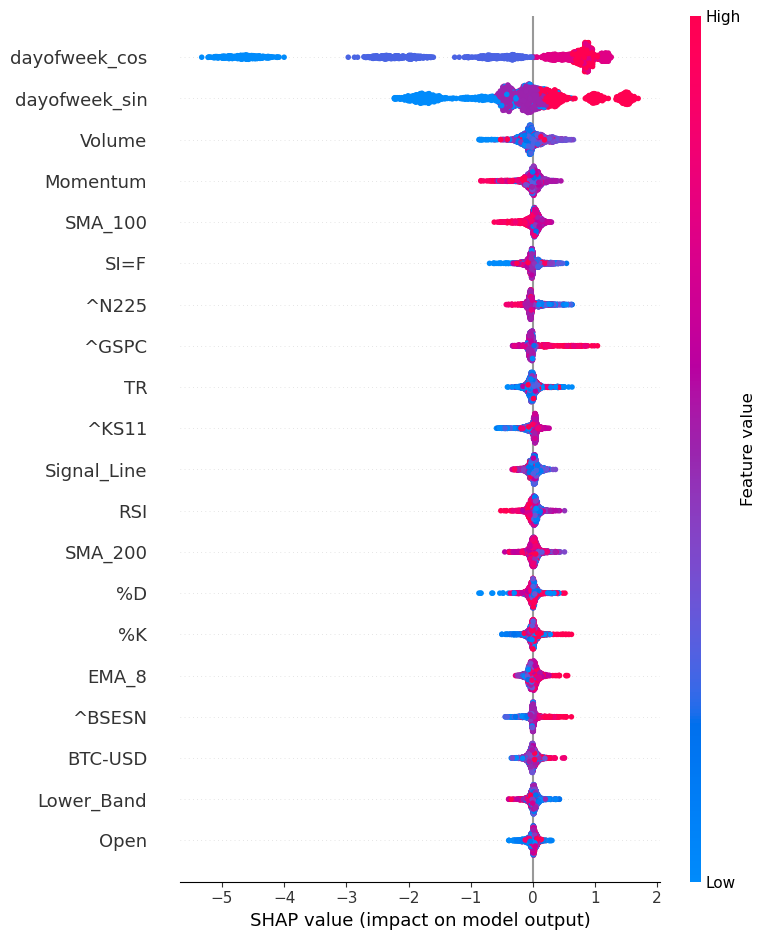

In [13]:
best_params = study.best_params

best_model = xgb.XGBClassifier(objective="binary:logistic",
                               eval_metric="logloss", 
                               random_state=42,
                               n_estimators=best_params['n_estimators'],
                               learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'],
                               gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

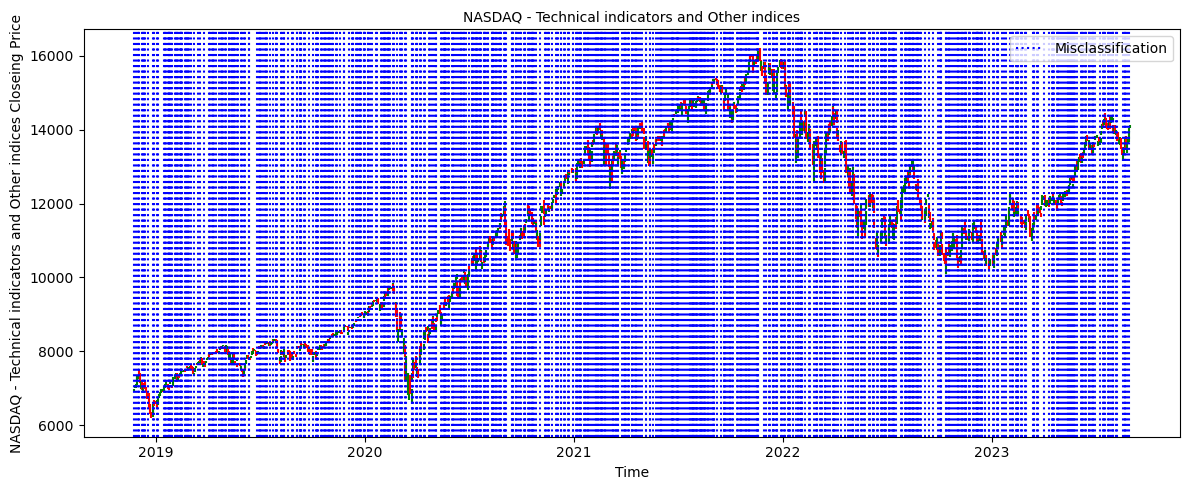

In [14]:
plot_df = df_NASDAQ

plot_predictions(plot_df,
                 y_pred,
                 ticker = "NASDAQ - Technical indicators and Other indices",
                 classification = True)

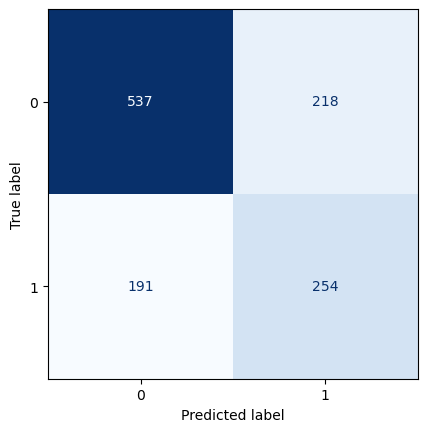

In [15]:
cf_matrix = met.confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, y_pred)
func_list.append(accuracy)
precision = met.precision_score(y_test, y_pred)
func_list.append(precision)
recall = met.recall_score(y_test, y_pred)
func_list.append(recall)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

## Predicting NASDAQ Close Price with XGBoost using Technical indicators, Other indices and Feature Engine

In [16]:
func_list = ["Technical Indicators, Other Indices and Feature Engine"]

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)

    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ('winsorizer', fout.Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=columns_with_outliers)),
        ('scaler', pre.MinMaxScaler()),
        ('drop_duplicate', fsel.DropDuplicateFeatures()),
        ('drop_correlated', fsel.DropCorrelatedFeatures()),
        ('drop_constant', fsel.DropConstantFeatures(tol=0.998)),
        ('rfa', fsel.RecursiveFeatureAddition(estimator=xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss"), scoring="f1")),
        ('classifier', xgb.XGBClassifier(objective="binary:logistic",
                                     eval_metric="logloss",
                                     random_state=42,
                                     n_estimators=n_estimators,
                                     learning_rate=learning_rate,
                                     max_depth=max_depth,
                                     gamma=gamma))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return met.f1_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-08-31 19:01:10,777] A new study created in memory with name: no-name-11da24dd-837f-4044-88a3-64c755678664


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-31 19:01:52,893] Trial 8 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 134, 'learning_rate': 0.007738456519642637, 'max_depth': 11, 'gamma': 0.003040506091338349}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:01:53,401] Trial 7 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 200, 'learning_rate': 0.004606753455840562, 'max_depth': 10, 'gamma': 0.01646455530280427}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:01:54,102] Trial 2 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 159, 'learning_rate': 0.03499864324996541, 'max_depth': 10, 'gamma': 0.007517567003504509}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:01:54,319] Trial 6 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 120, 'learning_rate': 0.014454484156386019, 'max_depth': 14, 'gamma': 0.0014098468293930418}. Best is trial 8 with value: 0.6830391404451267.
[

[I 2023-08-31 19:03:33,537] Trial 34 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 212, 'learning_rate': 0.015300650048116128, 'max_depth': 10, 'gamma': 0.006750274859753699}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:03:34,524] Trial 35 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 217, 'learning_rate': 0.014777930063022124, 'max_depth': 10, 'gamma': 0.0068440144581892485}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:04:07,599] Trial 36 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 196, 'learning_rate': 0.014699468701698255, 'max_depth': 10, 'gamma': 0.0072249775952884406}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:04:08,271] Trial 37 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 217, 'learning_rate': 0.014687748219927993, 'max_depth': 10, 'gamma': 0.007115177526980073}. Best is trial 8 with value: 0.683039140445

[I 2023-08-31 19:05:49,513] Trial 67 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 372, 'learning_rate': 0.009433077721290125, 'max_depth': 8, 'gamma': 0.009040293407256397}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:05:50,964] Trial 68 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 304, 'learning_rate': 0.00927682406719468, 'max_depth': 8, 'gamma': 0.008579328290496001}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:05:51,172] Trial 69 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 264, 'learning_rate': 0.009806555227409124, 'max_depth': 8, 'gamma': 0.008184247748159502}. Best is trial 8 with value: 0.6830391404451267.
[I 2023-08-31 19:05:53,718] Trial 70 finished with value: 0.6830391404451267 and parameters: {'n_estimators': 370, 'learning_rate': 0.01019421769149998, 'max_depth': 8, 'gamma': 0.01983260706462553}. Best is trial 8 with value: 0.6830391404451267.
[I 

In [17]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 0.6830391404451267
Params: 
    n_estimators: 134
    learning_rate: 0.007738456519642637
    max_depth: 11
    gamma: 0.003040506091338349


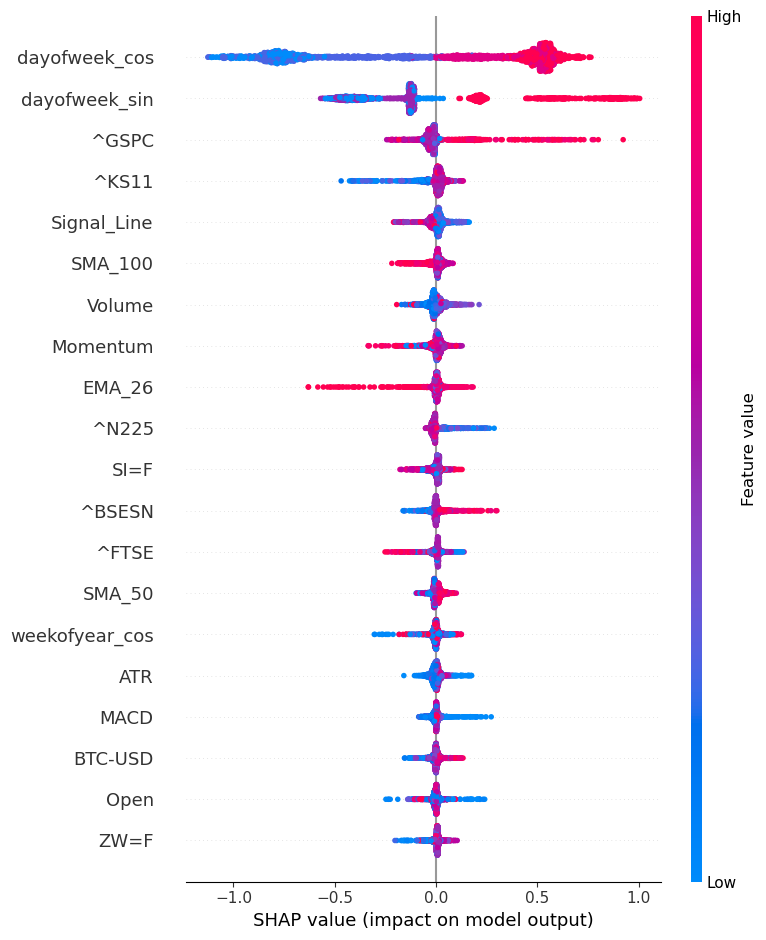

In [18]:
best_params = study.best_params

best_model = xgb.XGBClassifier(objective="binary:logistic",
                               eval_metric="logloss", 
                               random_state=42,
                               n_estimators=best_params['n_estimators'],
                               learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'],
                               gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

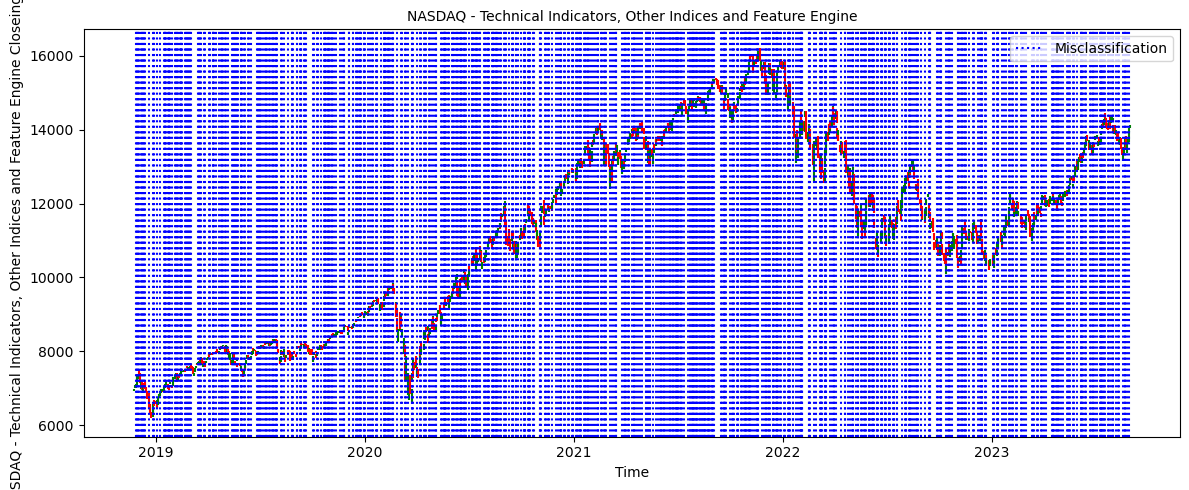

In [19]:
plot_df = df_NASDAQ

plot_predictions(plot_df,
                 y_pred,
                 ticker = "NASDAQ - Technical Indicators, Other Indices and Feature Engine",
                 classification = True)

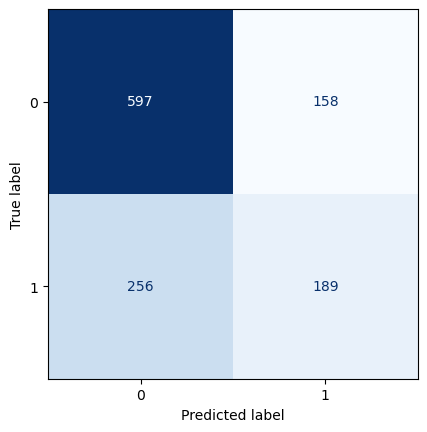

In [20]:
cf_matrix = met.confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, y_pred)
func_list.append(accuracy)
precision = met.precision_score(y_test, y_pred)
func_list.append(precision)
recall = met.recall_score(y_test, y_pred)
func_list.append(recall)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

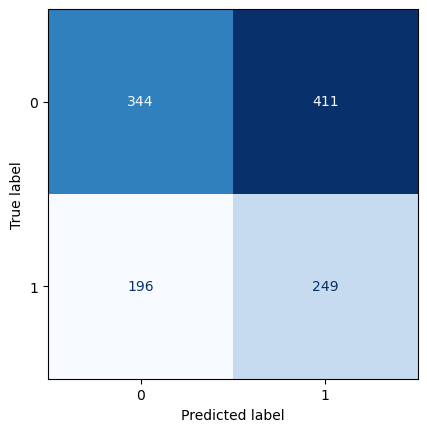

In [29]:
naive_NASDAQ = (df_NASDAQ.Close.shift(-1).pct_change() > 0).astype(int)[-len(y_test):]

func_list = ["Naive Predictions"]

f1 = met.f1_score(y_test, naive_NASDAQ)
func_list.append(f1)
func_list.append("Naive Predictions")

cf_matrix = met.confusion_matrix(y_test, naive_NASDAQ)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test, naive_NASDAQ)
func_list.append(accuracy)
precision = met.precision_score(y_test, naive_NASDAQ)
func_list.append(precision)
recall = met.recall_score(y_test, naive_NASDAQ)
func_list.append(recall)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [31]:
df_results_base = pd.DataFrame(explanations, columns=["Explanation", "F1", "Best Params", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall"])
df_results_base.set_index("Explanation", inplace = True)
df_results_base

,F1,Best Params,TN,FP,FN,TP,Accuracy,Precision,Recall
Explanation,,,,,,,,,
Only technical indicators,0.602493,"{'n_estimators': 147, 'learning_rate': 0.00122...",185,355,221,439,0.520000,0.552897,0.665152
Technical Indicators and Other Indices,0.577633,"{'n_estimators': 216, 'learning_rate': 0.02697...",537,218,191,254,0.659167,0.538136,0.570787
"Technical Indicators, Other Indices and Feature Engine",0.683039,"{'n_estimators': 134, 'learning_rate': 0.00773...",597,158,256,189,0.655000,0.544669,0.424719
Naive Predictions,0.450679,Naive Predictions,344,411,196,249,0.494167,0.377273,0.559551


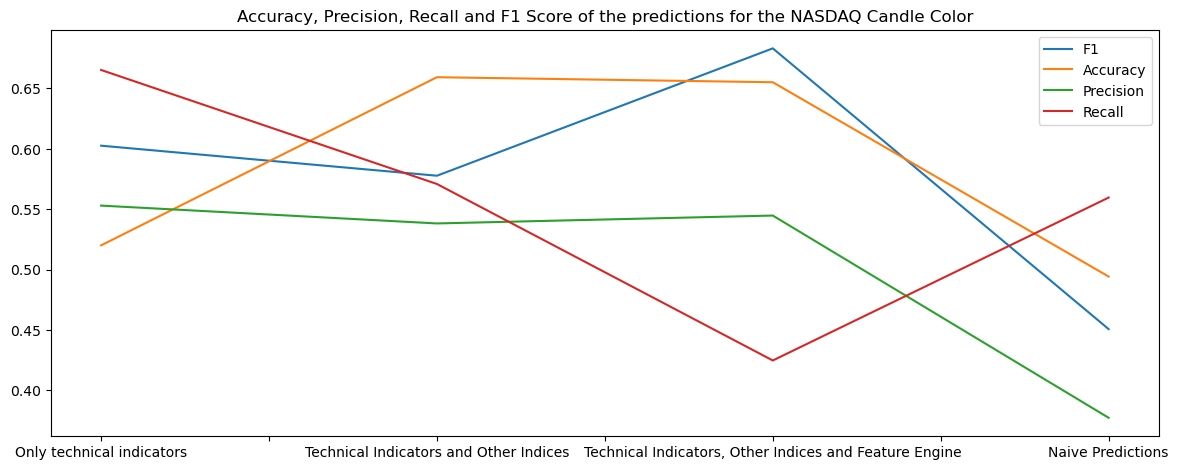

In [35]:
df_results_base[["F1", "Accuracy", "Precision","Recall"]].plot(figsize = (12,5))
plt.title("Accuracy, Precision, Recall and F1 Score of the predictions for the NASDAQ Candle Color")
plt.tight_layout()
plt.xlabel("")
plt.show()